In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
import shap


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Reading in the data and getting and overview

In [2]:
# Starting with 10k observations that have NA values filled from KNN imputation
df0 = pd.read_csv('na_filled_df.csv')
df0 = df0.sample(n=35000, random_state=2025)
df = df0
df.shape

(35000, 81)

In [3]:
print(df.head())
df.columns

       activity_year  derived_msa-md  county_code  census_tract  action_taken  \
47390         2019.0         19740.0       8005.0  8.005006e+09           1.0   
38566         2019.0             0.0      60195.0  6.019502e+10           5.0   
32814         2019.0         99999.0      55115.0  5.511510e+10           1.0   
41393         2019.0         46340.0      48423.0  4.842300e+10           4.0   
12564         2019.0         99999.0      27115.0  2.711595e+10           6.0   

       purchaser_type  preapproval  loan_type  loan_purpose  lien_status  ...  \
47390            71.0          2.0        1.0           1.0          1.0  ...   
38566             0.0          2.0        2.0           1.0          1.0  ...   
32814             0.0          2.0        1.0          32.0          1.0  ...   
41393             0.0          2.0        1.0          32.0          1.0  ...   
12564             2.0          2.0        3.0           1.0          1.0  ...   

       derived_loan_produc

Index(['activity_year', 'derived_msa-md', 'county_code', 'census_tract',
       'action_taken', 'purchaser_type', 'preapproval', 'loan_type',
       'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open-end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'origination_charges',
       'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization',
       'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'construction_method',
       'occupancy_type', 'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'income',
       'debt_to_income_ratio', 'applicant_credit_score_type',
       'co-applicant_credit_score_type', 'applicant_ethnicity-1',
       'applicant_ethnicity-2', 'co-applicant_ethnicity-1',
    

action_taken
1.0    53.288571
3.0    14.080000
6.0    13.142857
4.0    12.297143
5.0     4.060000
2.0     2.194286
8.0     0.482857
7.0     0.454286
Name: count, dtype: float64


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='action_taken', ylabel='count'>

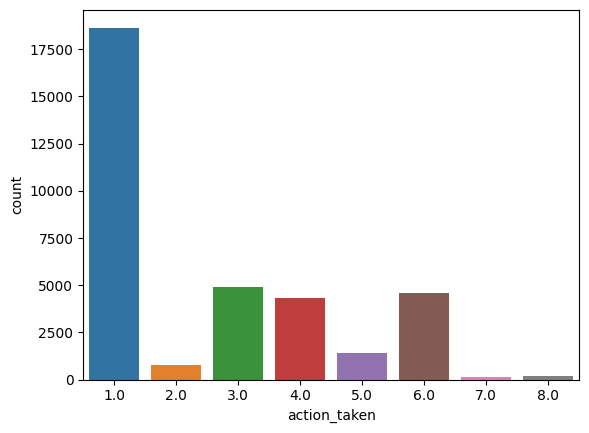

In [4]:
# Looking at the percentage of each action type
print(df['action_taken'].value_counts()/len(df)*100)
sns.countplot(x='action_taken', data=df)

In [5]:
# Converting target variable to binary
df['action_taken'] = df['action_taken'].apply(lambda x: 1 if x in [1,2,6] else 0)

****

### Data cleaning and feature selection

In [7]:
columns_to_select = ['action_taken', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'preapproval', 
                     'loan_purpose', 'lien_status', 'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio',
                      'rate_spread', 'total_loan_costs', 'loan_term', 'negative_amortization', 'occupancy_type', 'income', 'debt_to_income_ratio']
df0 = df[columns_to_select]
df0.shape

(35000, 20)

In [8]:
# Finding categorical variables
string_columns = df0.select_dtypes(include=['object']).columns
string_df = df0[string_columns]
print(string_columns)

Index(['conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category'],
      dtype='object')


In [9]:
# Seeing how many unique values each category has
unique_counts = {}

for column in string_columns:
    unique_counts[column] = df[column].nunique()

unique_counts

{'conforming_loan_limit': 3,
 'derived_loan_product_type': 6,
 'derived_dwelling_category': 3}

In [10]:
# Making sure these are strings and not mixed data types
df['applicant_sex'] = df['applicant_sex'].astype(str)
df['applicant_age_above_62'] = df['applicant_age_above_62'].astype(str)
df['derived_race'] = df['derived_race'].astype(str)
df_dummies = pd.get_dummies(df0, columns=string_columns, drop_first=True)
df_dummies.shape

(35000, 26)

## Building a random forest model

In [11]:
# Splitting the data
y = df_dummies['action_taken']
X = df_dummies.drop(columns='action_taken')
# Inlcuding the sensitive features also to use later in Fairlearn
sensitive_features_data = df[['applicant_sex', 'applicant_age_above_62', 'derived_race']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)
sensitive_features_train, sensitive_features_test = train_test_split(sensitive_features_data, test_size=0.25, random_state=2023)

Accuracy: 0.7833
Precision: 0.8002
Recall: 0.9093
F1 Score: 0.8513
Confusion Matrix:


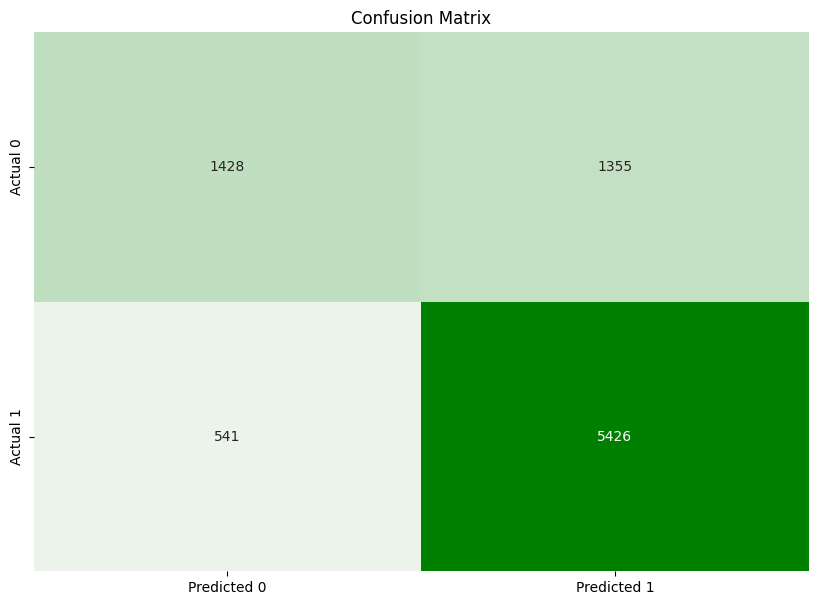

In [12]:
# Building the random forest model
np.random.seed(2023)
rf0 = RandomForestClassifier(n_estimators=100, random_state=2023)
rf0.fit(X_train, y_train)

# Generating predictions and displaying the confusion matrix
y_pred = rf0.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Create a custom color map
cmap = sns.light_palette("green", as_cmap=True)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.show()

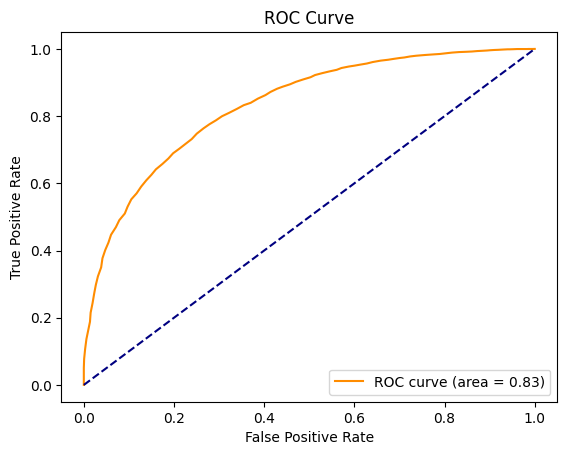

In [13]:
# Plotting the ROC curve
y_prob = rf0.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()  

In [14]:
importances = rf0.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [X.columns[idx] for idx in sorted_indices]

sorted_features_with_importance = []
for i, idx in enumerate(sorted_indices):
    feature_name = X.columns[idx]
    importance_value = importances[idx]
    print(f"{i + 1}. {feature_name} ({importance_value})")
    sorted_features_with_importance.append((feature_name, importance_value))

1. rate_spread (0.14152774700890808)
2. loan_to_value_ratio (0.12997777021168208)
3. total_loan_costs (0.12264946857372765)
4. total_loan_costs (0.12094749427962763)
5. income (0.11513562774688298)
6. loan_amount (0.09695557382149972)
7. debt_to_income_ratio (0.08830499696767459)
8. loan_purpose (0.048728397891057804)
9. loan_term (0.034423601289662445)
10. derived_loan_product_type_FHA:First Lien (0.01744073980662746)
11. open-end_line_of_credit (0.012674963459637556)
12. derived_loan_product_type_VA:First Lien (0.010915116210925517)
13. occupancy_type (0.010144051698643566)
14. derived_dwelling_category_Single Family (1-4 Units):Manufactured (0.00759716336790606)
15. business_or_commercial_purpose (0.007173109304716071)
16. preapproval (0.006124832781691708)
17. lien_status (0.005121936437536797)
18. derived_dwelling_category_Single Family (1-4 Units):Site-Built (0.005032328790357081)
19. derived_loan_product_type_Conventional:Subordinate Lien (0.004991164403668415)
20. reverse_mortg

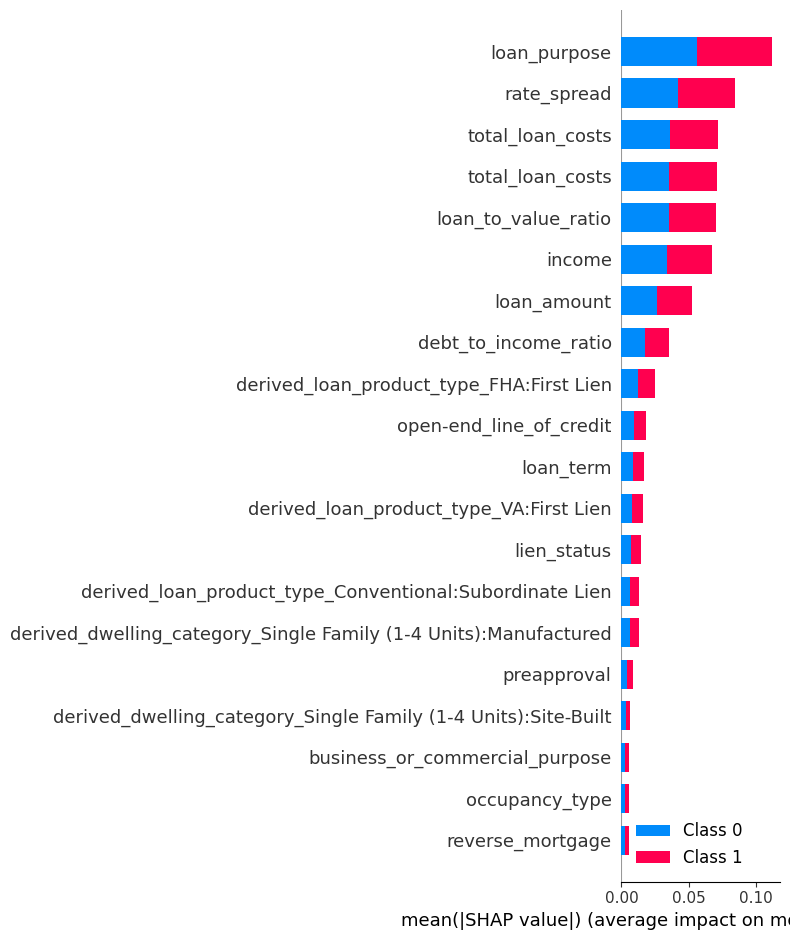

In [15]:
# # Getting shapley values
# # Initializing SHAP explainer
explainer = shap.TreeExplainer(rf0)

# Compute Shapley values for the test set
shap_values = explainer.shap_values(X_test)

# Visualization of SHAP values
shap.summary_plot(shap_values, X_test)

****

## Looking into metrics with Microsoft Fairlearn

In [16]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate

In [17]:
sensitive_features_test

,applicant_sex,applicant_age_above_62,derived_race
43867,2.0,No,White
27739,1.0,No,White
10689,2.0,No,White
687,2.0,No,White
16423,2.0,No,White
...,...,...,...
38764,4.0,nan,Race Not Available
13546,2.0,No,White
12498,1.0,No,White
45317,3.0,No,Race Not Available


In [18]:
# Accuracy by race
mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(mf.overall)
mf.by_group

0.7833142857142857


DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


derived_race
2 or more minority races                     0.800000
American Indian or Alaska Native             0.777778
Asian                                        0.752860
Black or African American                    0.752244
Joint                                        0.754286
Native Hawaiian or Other Pacific Islander    0.833333
Race Not Available                           0.798522
White                                        0.783981
Name: accuracy_score, dtype: float64

In [19]:
# Selection rate is the percentage of the population that is labeled '1'
sr = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(sr.overall)
sr.by_group

0.7749714285714285


DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


derived_race
2 or more minority races                     0.500000
American Indian or Alaska Native             0.666667
Asian                                        0.839817
Black or African American                    0.649910
Joint                                        0.777143
Native Hawaiian or Other Pacific Islander    0.500000
Race Not Available                           0.791133
White                                        0.778872
Name: selection_rate, dtype: float64

In [20]:
# Manually defining FPR and FNR
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Define False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Define Selection Rate
def selection_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Define Count (this is simply the length of y_pred)
def count(y_true, y_pred):
    return len(y_pred)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


array([[<Axes: title={'center': 'accuracy'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'precision'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='applicant_sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'count'}, xlabel='applicant_sex'>],
       [<Axes: xlabel='applicant_sex'>, <Axes: xlabel='applicant_sex'>,
        <Axes: xlabel='applicant_sex'>]], dtype=object)

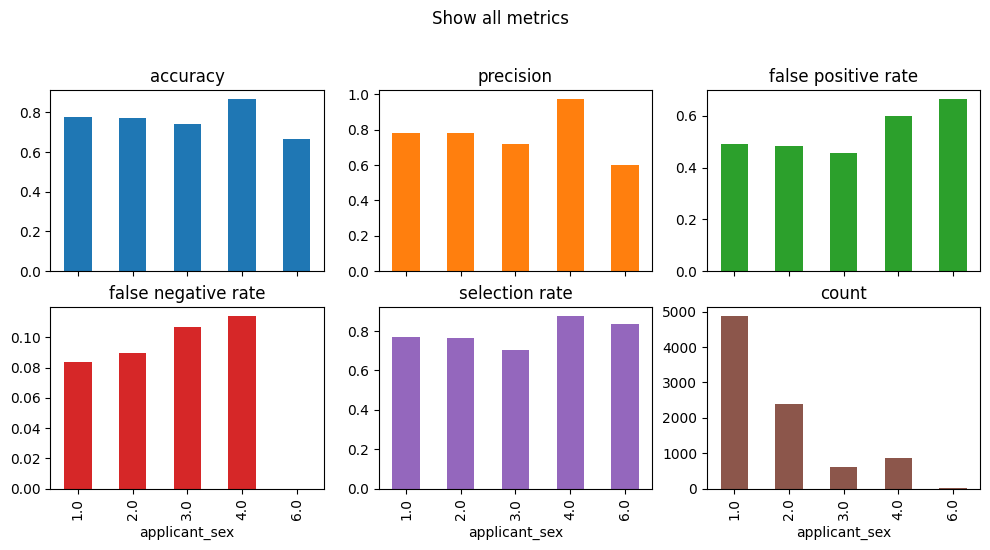

In [21]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_sex'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


array([[<Axes: title={'center': 'accuracy'}, xlabel='derived_race'>,
        <Axes: title={'center': 'precision'}, xlabel='derived_race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='derived_race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='derived_race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='derived_race'>,
        <Axes: title={'center': 'count'}, xlabel='derived_race'>],
       [<Axes: xlabel='derived_race'>, <Axes: xlabel='derived_race'>,
        <Axes: xlabel='derived_race'>]], dtype=object)

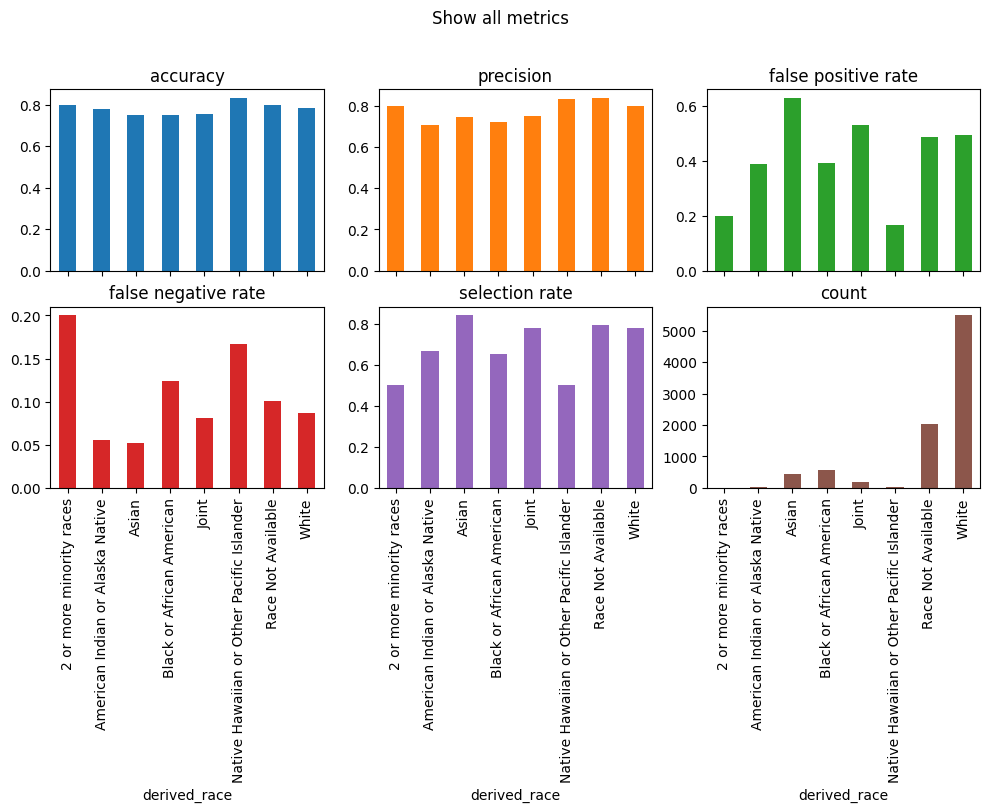

In [22]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


array([[<Axes: title={'center': 'accuracy'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'precision'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='applicant_age_above_62'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'selection rate'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'count'}, xlabel='applicant_age_above_62'>],
       [<Axes: xlabel='applicant_age_above_62'>,
        <Axes: xlabel='applicant_age_above_62'>,
        <Axes: xlabel='applicant_age_above_62'>]], dtype=object)

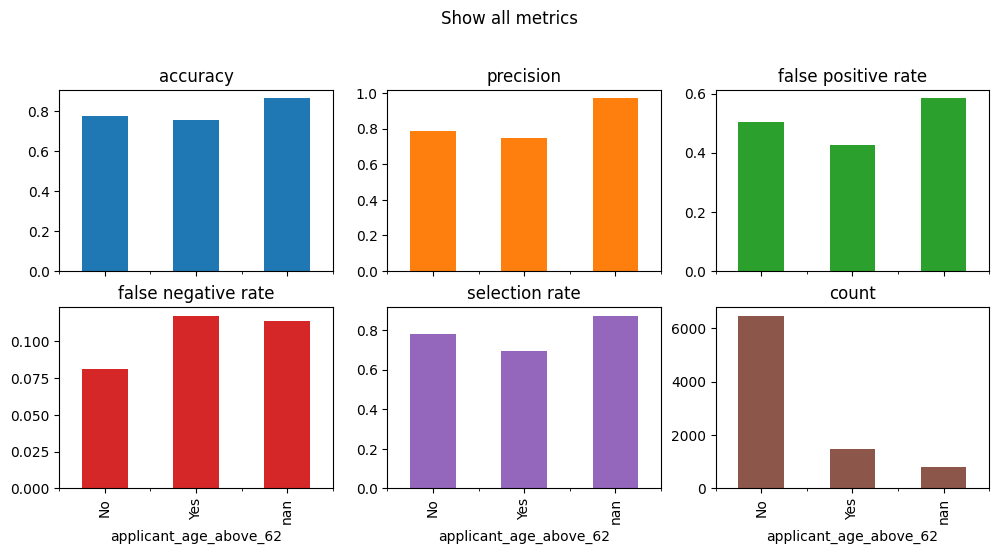

In [23]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, 
    y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_age_above_62'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

derived_race
White                                        62.808571
Race Not Available                           23.125714
Black or African American                     6.371429
Asian                                         5.028571
Joint                                         1.811429
American Indian or Alaska Native              0.457143
Native Hawaiian or Other Pacific Islander     0.237143
2 or more minority races                      0.140000
Free Form Text Only                           0.020000
Name: count, dtype: float64


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='derived_race', ylabel='count'>

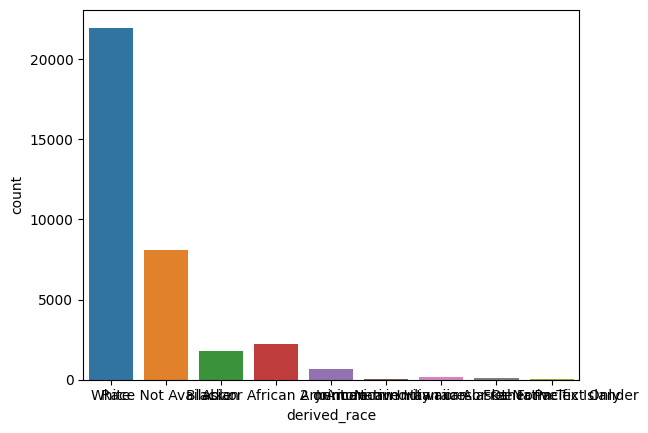

In [24]:
# Getting errors for race and sex metrics. It seems that some groups are too small and causing errors.
print(df['derived_race'].value_counts()/len(df)*100)
sns.countplot(x='derived_race', data=df)

applicant_sex
1.0    55.740000
2.0    27.548571
4.0     9.762857
3.0     6.894286
6.0     0.054286
Name: count, dtype: float64


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='applicant_sex', ylabel='count'>

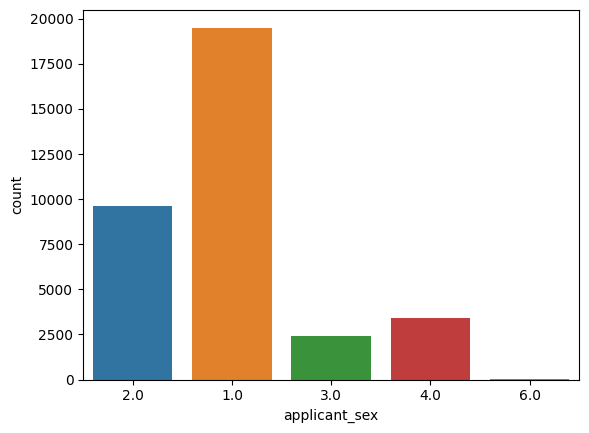

In [25]:
print(df['applicant_sex'].value_counts()/len(df)*100)
sns.countplot(x='applicant_sex', data=df)

In [26]:
# In race 'free form text' and in sex '6' the categories are too small. This means that if they only appear in one class you cannot generate a confusion matrix which causes issues. Consider dropping these categories.

### Updating the objective function with Exponentiated Gradient mitigation  using Demographic Parity as the objective

In [ ]:
from fairlearn.reductions import DemographicParity, ExponentiatedGradient

In [ ]:
rf0 = RandomForestClassifier(n_estimators=100, random_state=2023)
rf0.fit(X_train, y_train)

RandomForestClassifier(random_state=2023)

In [ ]:
np.random.seed(2023)

constraint = DemographicParity()
classifier = RandomForestClassifier(n_estimators=100, random_state=2023)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_train, y_train, sensitive_features=sensitive_features_train['applicant_age_above_62'])

y_pred_mitigated = mitigator.predict(X_test)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

KeyboardInterrupt: 

In [ ]:
# Getting mitigated selection rate
sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=sensitive_features_test['applicant_age_above_62'])
print(sr_mitigated.overall)
sr_mitigated.by_group

0.6523428571428571


c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


applicant_age_above_62
No     0.650131
Yes    0.650000
nan    0.674593
Name: selection_rate, dtype: float64

In [ ]:
# Comparing mitigated selection rate above to normal selection rate
sr = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_age_above_62'])
print(sr.overall)
sr.by_group

0.6662857142857143


c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


applicant_age_above_62
No     0.650286
Yes    0.568919
nan    0.976220
Name: selection_rate, dtype: float64